# Importing Library

In [ ]:
library(dplyr)
library(data.table)
library(Matrix)
library(xgboost)
library(ranger)
library(caret)
library(lightgbm)
library(stringr)

# Loading dataset

In [ ]:
train <- fread("../input/toto_train.csv",stringsAsFactors = F)
test <- fread("../input/toto_test.csv",stringsAsFactors = F)
analyst_pick <- fread("../input/analyst_pick.csv",stringsAsFactors = F)
submission <- fread("../input/submission.csv")

In [ ]:
glimpse(train)
glimpse(test)
glimpse(analyst_pick)

* train data 9340개의 관측값과 8개의 변수를 가지고 있다. 
* test data는 2797개의 관측값과 7개의 변수로 이루어져있다.
* analyst_pick은 wisetoto의 분석위원들이 어떤 예측을 했는지에 대한 데이터로 이루어져 있고, 24551개의 관측값과 3개의 변수로 이루어져 있다.

* game_id: 게임별 고유 아이디
* date: 경기 날짜
* win_percentage: 경기별로 사람들이 어떤 선택을 했고 각각의 배당률이 어떻게 되는지 정보
* home_team: 홈 팀의 정보
* away_team: 원정 팀의 정보
* home_team_recent_10: 홈 팀의 최근 10경기 성적
* away_team_recent_10: 원정 팀의 최근10경기 성적
* result: 결과 (1: 홈 팀 승, 0: 원정 팀 승)


먼저 Preprocessing 및 Feature Engineering이 용이하게 train data와 test 데이터를 병합한다.

In [ ]:
train$Train_or_Test <- "Train"
test$Train_or_Test <- "Test"
test$result <- NA

all <- rbind(train,test)

## Missing value 

In [ ]:
colSums(is.na(train))
colSums(is.na(test))
colSums(is.na(analyst_pick))

제공된 데이터에서 missing value가 존재하지 않았다. 그러나 공백값으로 존재하는 missing value가 존재할 가능성이 있다.

## 탐색적자료분석
### 1.Main Data
0. result
1. win_percentage
2. home_team_recent_10
3. away_team_recent_10

### 2.Analysis_Pick

## 0. result: 결과(1: 홈 팀 승, 0: 원정 팀 승)
이 분석의 label값인 result 변수를 확인하여 데이터가 balanced data인지, imbalanced data인지 확인해야 한다.

In [ ]:
ggplot(all[!is.na(all$result),], aes(x = result,fill = factor(result)))+
geom_bar(position = position_dodge())

In [ ]:
table(all[!is.na(all$result),'result'])

홈 팀의 승리 횟수는 5330번, 원정 팀의 승리 횟수는 4010번이라는 것을 알 수 있다.

## 1. win_percentage
해당 변수는 홈팀을 기준으로 승리 배당률(선택률) 무승부 배당률(선택률) 패배 배당률(선택률)로 이루어져 있다. 따라서 이 변수를 이용해 새로운 변수를 만들 필요가 있다. 해당 변수에 두 개의 배당률만 존재할 경우에는 승리 배당률(선택률) 패배 배당률(선택률)로 이루어진 것이다.

먼저, 승리 무승부 패배를 모두 포함하는 관측값과 승리 패배만 포함하는 관측값을 추출한다. 

In [ ]:
temp <- strsplit(all$win_percentage," ")
len <- vector()
for (i in 1:length(temp)){
    len[i] = length(temp[[i]])
}

all$win_percentage_str_len <- len
unique(len)

6일 경우, 승리 무승부 패배를 모두 포함하는 관측값이고, 4일 경우 승리와 패배만 포함하는 관측값이다. 따라서 이를 이용하여 배당률과 선택비율 변수를 생성해준다.

In [ ]:
len_4_loc <- which(all$win_percentage_str_len == 4)

for (i in len_4_loc){
    all[i,'win_div_rat'] = unlist(temp[i])[1]
    all[i,'win_pick_rat'] = unlist(temp[i])[2]
    all[i,'lose_div_rat'] = unlist(temp[i])[3]
    all[i,'lose_pick_rat'] = unlist(temp[i])[4]
}

len_6_loc <- which(all$win_percentage_str_len == 6)

for (i in len_6_loc){
    all[i,'win_div_rat'] = unlist(temp[i])[1]
    all[i,'win_pick_rat'] = unlist(temp[i])[2]
    all[i,'draw_div_rat'] = unlist(temp[i])[3]
    all[i,'draw_pick_rat'] = unlist(temp[i])[4]
    all[i,'lose_div_rat'] = unlist(temp[i])[5]
    all[i,'lose_pick_rat'] = unlist(temp[i])[6]
}

In [ ]:
all$win_pick_rat <- as.numeric(gsub("([(\\%)])","",all$win_pick_rat)) / 100
all$draw_pick_rat <- as.numeric(gsub("([(\\%)])","",all$draw_pick_rat)) / 100
all$lose_pick_rat <- as.numeric(gsub("([(\\%)])","",all$lose_pick_rat)) / 100

In [ ]:
head(all)

## 1. home_team_recent_10 & away_team_recent
해당 변수는 기본적으로 o승o무o패로 이루어져있다. 이런 형식으로 구성되지 않은 관측값도 존재하는데, 왜 이런 값이 나왔는지 찾아 볼 필요가 있다.
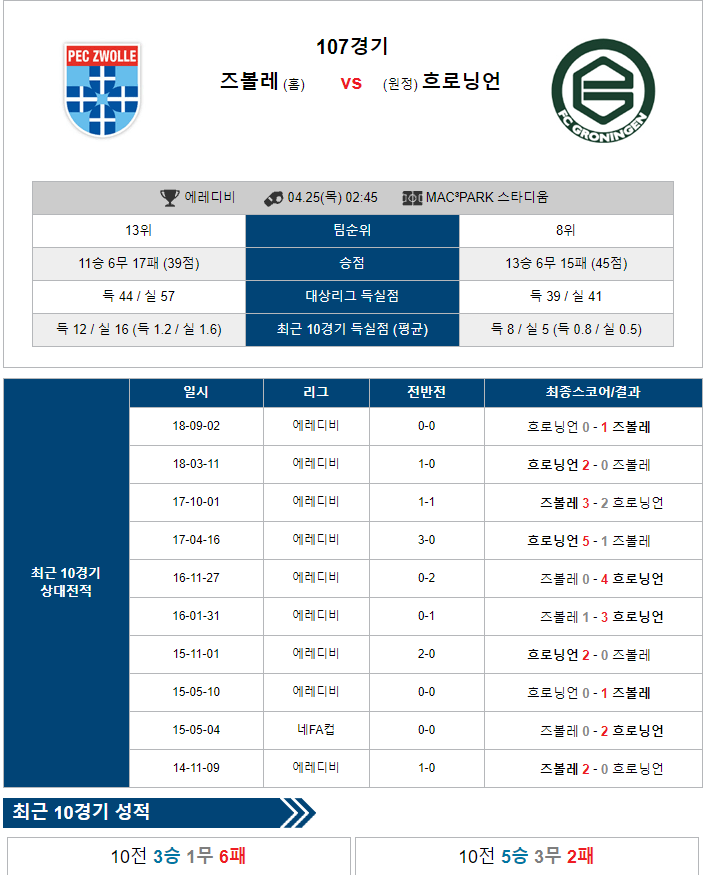

In [ ]:
all %>% filter(home_team_recent_10 == "3.152.653승")

실제 경기 결과표와 데이터 내에 존재하는 경기 결과를 확인해본 결과, 다소 차이가 있었다. 

away_team_recent_10의 무,패가 혹시 home_team_recent_10의 무,패가 아닌지 의심이 든다. 


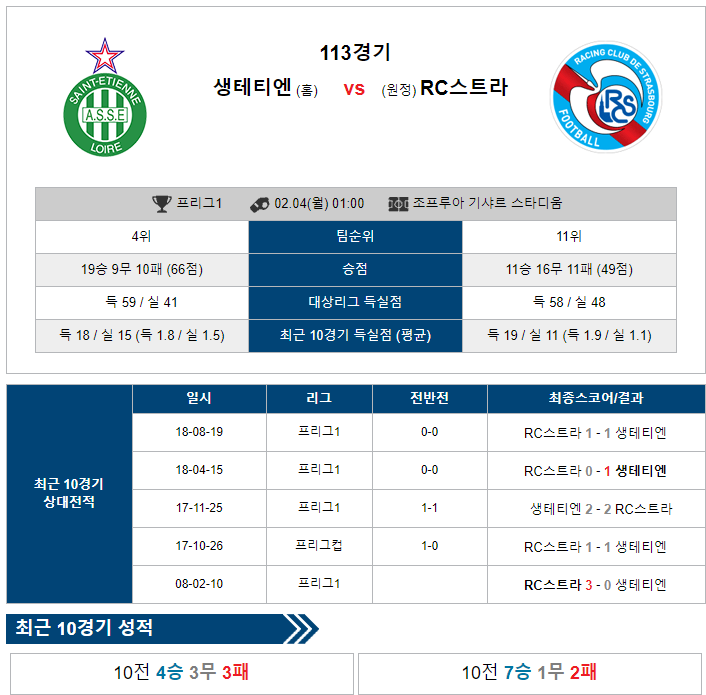

In [ ]:
all %>% filter(home_team_recent_10 == "3.153.454승")

데이터의 home_team_recent_10이 3.153.454승이고, 실제 최근 10경기 성적은 4승 3무 3패로 나왔다. 제일 앞의 3이 패, 153의 3이 무, 454의 4가 승으로 저장되있는건지 다른 관측값도 확인해 볼 필요가 있다.

또한, away_team_recent_10은 원정 팀의 최근 10경기 성적인데, 3무 3패 7승은 경기 수가 13경기이다. 무언가가 이상하다.



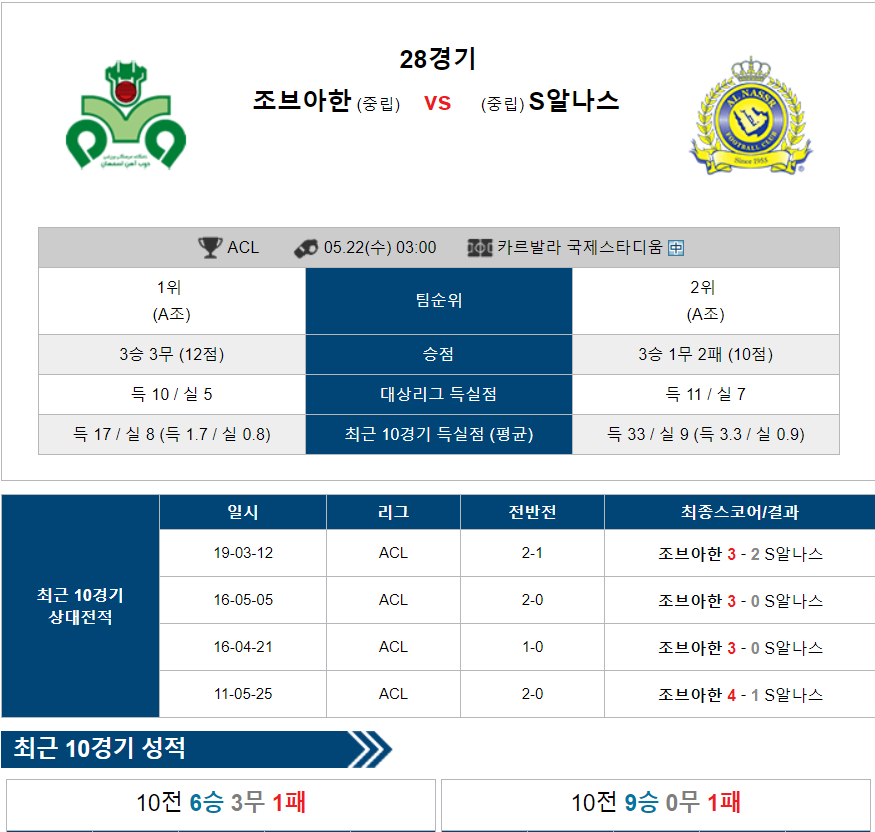

In [ ]:
all %>% filter(home_team_recent_10 == "3.102.906승")

3개의 경기를 확인해본 결과, away_team_recent_10이 10경기를 넘기는 경우 home_team_recent_10이 이상한 값을 가지는 경향을 보인다는 것을 알 수 있었다. 또한 이런 경우, 원정팀의 무패가 홈팀의 무패라는 것, o무o패o승 형식으로 나타난다는 것을 알 수 있었다.

그렇다면 원정팀의 무패는 어디서 찾을 수 있을까?

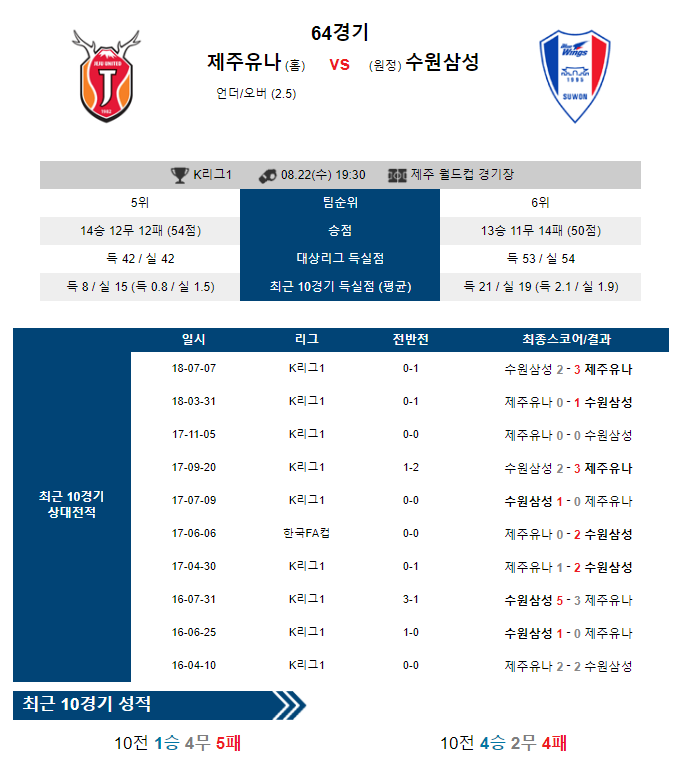

In [ ]:
all %>% filter(away_team_recent_10 == "5패4승2무")

그 밖에, 무패승 형식이 아닌 패승무 형식으로 저장된 관측값도 1개 존재했다. 이 경우에는 home_team_recent_10에 1승4무가 이미 존재했고, away_team_recent_10에서 5패를 가져와, 홈 팀의 최근 10경기 성적은 1승4무5패로 처리한다. 또한 원정팀의 승무가 확실히 일치하기 때문에 자동으로 4패를 계산할 수 있을 것이다.

In [ ]:
all[all$game_id==9401,]$home_team_recent_10 <- "1승4무5패"
all[all$game_id==9401,]$away_team_recent_10 <- "4승2무4패"
all[all$game_id==9401,]

### 변수생성: 홈팀 승,무,패  원정팀 승,무,패

In [ ]:
incorrect_away_list <- c("3무4패4승","1무3패8승","2무4패3승","4무3패3승","1무5패6승",
                       "4무1패2승","2무2패6승","5무4패4승","2무7패4승","0무4패3승",
                       "2무5패2승","5무2패3승","5무3패7승","3무5패5승","1무0패4승",
                       "1무8패1승","3무0패2승","3무5패2승","4무3패2승","1무4패2승",
                       "3무4패3승","3무4패5승","0무7패3승","3무2패5승","3무6패3승",
                       "2무3패7승","4무5패4승","3무4패2승","3무3패7승","1무6패5승",
                       "3무1패9승") #19개

In [ ]:
for (i in 1:nrow(all)){
    if (all[i,"away_team_recent_10"] %in% incorrect_away_list == TRUE){
        all[i,"home_draw_recent_10"] <- as.numeric(str_sub(all[i,"away_team_recent_10"],1,1))
    }
    if  (all[i,"away_team_recent_10"] %in% incorrect_away_list == TRUE){
        all[i,"home_lose_recent_10"] <- as.numeric(str_sub(all[i,"away_team_recent_10"],3,3))
    }
    if (all[i,"away_team_recent_10"] %in% incorrect_away_list == TRUE){
        all[i,"away_win_recent_10"]  <- as.numeric(str_sub(all[i,"away_team_recent_10"],5,5))
    }
}

all$home_win_recent_10 <- 10 - all$home_draw_recent_10-all$home_lose_recent_10

In [ ]:
all %>% filter(away_team_recent_10 %in% incorrect_away_list)

In [ ]:
for (i in 1:nrow(all)){
    if(is.na(all[i,"home_win_recent_10"]) == TRUE) {
        all[i,"home_win_recent_10"]  <- as.numeric(str_sub(all[i,"home_team_recent_10"],1,1))
    }
    if(is.na(all[i,"home_draw_recent_10"]) == TRUE){
        all[i,"home_draw_recent_10"]  <- as.numeric(str_sub(all[i,"home_team_recent_10"],3,3))
    }
    if(is.na(all[i,"home_lose_recent_10"]) == TRUE){
        all[i,"home_lose_recent_10"]  <- as.numeric(str_sub(all[i,"home_team_recent_10"],5,5))
    }
}
# 최근 10경기 자체가 NA값인 관측값이 있기때문에 경고가 발생. 신경쓰지 않아도 된다.

home_team_recent_10과 away_team_recent_10 모두 "" 값을 가지고 있을 경우, 승무패를 0승0무0패로 처리한다.

In [ ]:
all$away_draw_recent_10 <- numeric()
all$away_lose_recent_10 <- numeric()

In [ ]:
for (i in 1:nrow(all)){
    if((all[i,"home_team_recent_10"]=="")&(all[i,"away_team_recent_10"]=="")){
        all[i,17:22] <- 0
    }
}

In [ ]:
for (i in 1:nrow(all)){
    if((is.na(all[i,"away_win_recent_10"]) == T) & (is.na(all[i,"away_draw_recent_10"]) == T) & (is.na(all[i,"away_lose_recent_10"]) == T)){
        all[i,"away_win_recent_10"]  <- as.numeric(str_sub(all[i,"away_team_recent_10"],1,1))
        all[i,"away_draw_recent_10"]  <- as.numeric(str_sub(all[i,"away_team_recent_10"],3,3))
        all[i,"away_lose_recent_10"]  <- as.numeric(str_sub(all[i,"away_team_recent_10"],5,5))
    }
}

In [ ]:
colSums(is.na(all))

In [ ]:
all[which(is.na(all$home_draw_recent_10)),]
#### 홈팀이 10승 0무 0패 했을 경우 na value 등장.

In [ ]:
all[which(is.na(all$home_draw_recent_10)),c("home_draw_recent_10","home_lose_recent_10")]  <- 0

In [ ]:
all[which(is.na(all$away_draw_recent_10)),]
## 내부 데이터로 알 수 없는 away팀의 무패. 0으로 대체한다.

In [ ]:
all[which(is.na(all$away_draw_recent_10)),c("away_draw_recent_10","away_lose_recent_10")] <- 0

In [ ]:
glimpse(all)
colSums(is.na(all))

마지막으로 무승부 배당률이 존재하지않는 관측값을 찾아 0으로 바꿔준다.

In [ ]:
all[which(is.na(all$draw_div_rat)),c("draw_div_rat","draw_pick_rat")] <- 0

In [ ]:
all$win_div_rat <- as.numeric(real_all$win_div_rat)
all$lose_div_rat <- as.numeric(real_all$lose_div_rat)
all$draw_div_rat  <- as.numeric(real_all$draw_div_rat)

In [ ]:
write.csv(all,"preprocessing_all.csv",row.names = F)